# Data Overview


In [41]:
import pandas as pd

# Load the datasets
rental_price_data = pd.read_csv('../data/rental_price.csv')
rating_features_data = pd.read_csv('../data/rating_features.csv')

print(rental_price_data.head())
print(rating_features_data.head())

print(rental_price_data.describe())
print(rating_features_data.describe())

     price
0  $300.00
1   $99.00
2  $100.00
3  $100.00
4  $599.00
   accommodates                                          amenities  \
0             6  {"Cable TV",Internet,"Wireless Internet","Air ...   
1             2  {"Air Conditioning",Heating,"Family/Kid Friend...   
2             2  {TV,"Cable TV",Internet,"Wireless Internet","A...   
3             2  {TV,"Cable TV",Internet,"Wireless Internet","A...   
4             6  {TV,"Cable TV",Internet,"Wireless Internet","A...   

   availability_30  bathrooms  bed_type  bedrooms  beds  \
0                0        2.5  Real Bed       1.0   3.0   
1               29        0.0     Futon       1.0   1.0   
2               30        1.5  Real Bed       1.0   1.0   
3               30        1.5  Real Bed       1.0   1.0   
4               27        2.0  Real Bed       3.0   3.0   

   calculated_host_listings_count cancellation_policy  guests_included  \
0                               1            moderate                1   
1         

# Nature of the Data

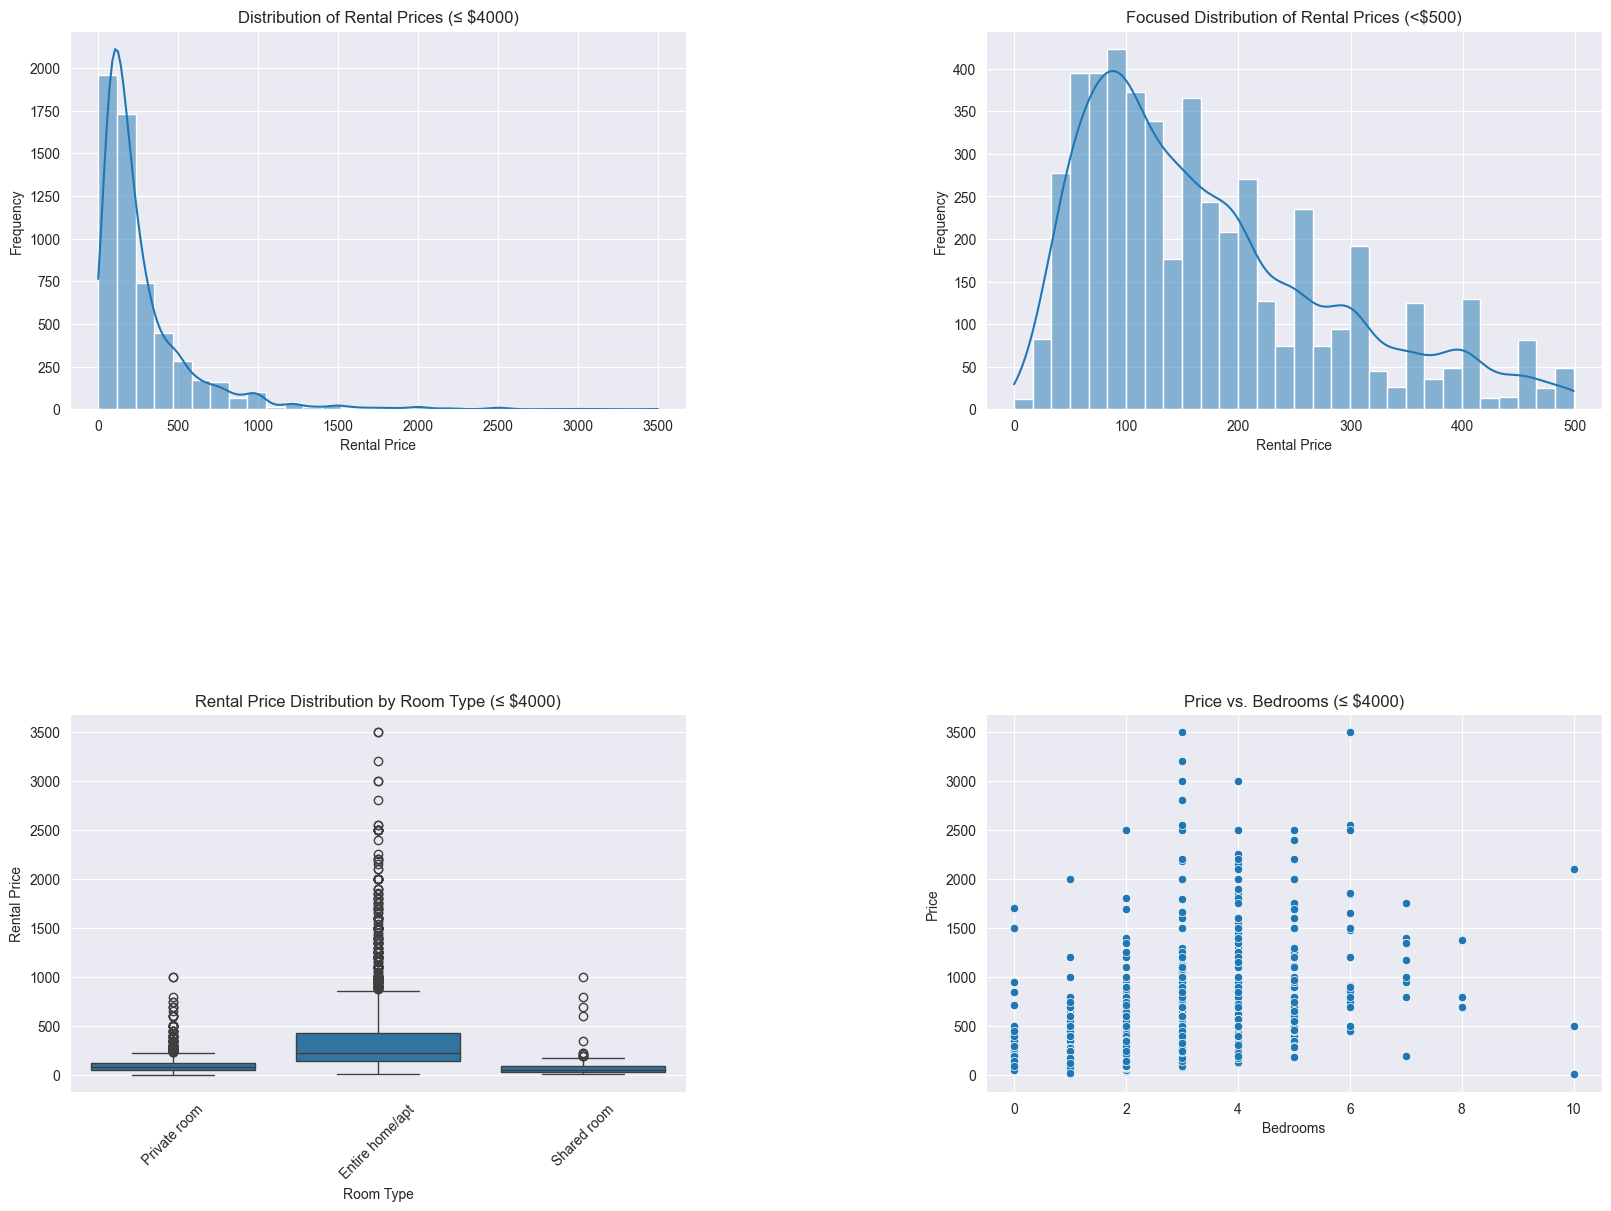

Note: Rental prices above $4000 have been excluded from the visualizations to allow for better display.


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

merged_df = pd.concat([rating_features_data, rental_price_data['price']], axis=1)

# Ensure 'price' is converted to numeric (float)
merged_df['price'] = pd.to_numeric(merged_df['price'].replace('[\$,]', '', regex=True), errors='coerce')

# Drop any rows where 'price' could not be converted and ended up as NaN
merged_df = merged_df.dropna(subset=['price'])

# Set up the figure for a 2x2 grid of plots with increased spacing and use constrained layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12), gridspec_kw={'hspace': 0.4, 'wspace': 0.3}, constrained_layout=True)

# Histogram of Rental Prices (excluding prices above $4000)
filtered_prices = merged_df[merged_df['price'] <= 4000]['price']
sns.histplot(filtered_prices, bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Rental Prices (≤ $4000)')
axes[0, 0].set_xlabel('Rental Price')
axes[0, 0].set_ylabel('Frequency')

# Focused Histogram of Rental Prices in a Main Area (e.g., prices below a threshold)
sns.histplot(merged_df[merged_df['price'] < 500]['price'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Focused Distribution of Rental Prices (<$500)')
axes[0, 1].set_xlabel('Rental Price')
axes[0, 1].set_ylabel('Frequency')

# Boxplot of Prices by Room Type (excluding prices above $4000)
sns.boxplot(x='room_type', y='price', data=merged_df[merged_df['price'] <= 4000], ax=axes[1, 0])
axes[1, 0].set_title('Rental Price Distribution by Room Type (≤ $4000)')
axes[1, 0].set_xlabel('Room Type')
axes[1, 0].set_ylabel('Rental Price')
axes[1, 0].tick_params(axis='x', rotation=45)

# Scatter Plot of Price vs. Bedrooms (excluding prices above $4000)
sns.scatterplot(x='bedrooms', y='price', data=merged_df[merged_df['price'] <= 4000], ax=axes[1, 1])
axes[1, 1].set_title('Price vs. Bedrooms (≤ $4000)')
axes[1, 1].set_xlabel('Bedrooms')
axes[1, 1].set_ylabel('Price')

# Adjust layout
plt.show()

# Note about excluded prices
print("Note: Rental prices above $4000 have been excluded from the visualizations to allow for better display.")

# Preprocessing

- we only look at key ameniteis based on their frequency in the data set and perosonal obsrvation on most important amenities.

### Missing Values
- for missing values bathrooms, beds, review_scores_checkin, review_scores_communication, review_scores_location,
review_scores_rating, review_scores_value mean was assesed. 
- for is host_is_superhost flase is assumed
- for host_listings_count 1 is assuemed. Therefor it is assumed that the host only has one listing.

In [43]:
from sklearn.preprocessing import MinMaxScaler

# Load the datasets
rental_price_data = pd.read_csv('../data/rental_price.csv')
rating_features_data = pd.read_csv('../data/rating_features.csv')

# Function to extract key amenities directly from the amenities string
def extract_key_amenities_directly(amenities):
    key_amenities = ['Internet', 'Wireless Internet', 'Kitchen', 'Heating', 'Essentials', 'TV',
                     'Washer', 'Dryer', 'Free parking on premises', 'Air conditioning', 'Breakfast',
                     'Pets allowed', 'Family/kid friendly', 'Suitable for events']
    # Normalize the amenities string for consistent matching
    amenities = amenities.lower().replace('"', '').replace('{', '').replace('}', '').replace(' ', '')
    features = {amenity: 1 if amenity.lower().replace(' ', '') in amenities else 0 for amenity in key_amenities}
    return pd.Series(features)

# Apply the function to extract key amenities and add them as new columns
key_amenities_df = rating_features_data['amenities'].apply(extract_key_amenities_directly)
rating_features_data = pd.concat([rating_features_data, key_amenities_df], axis=1)

# Optionally drop the original 'amenities' column if no longer needed
rating_features_data.drop('amenities', axis=1, inplace=True)

# Convert price from string to float
rental_price_data['price'] = rental_price_data['price'].replace('[\$,]', '', regex=True).astype(float)

# Check for missing values
print("Before Preproccessing")
print("Missing values in rental data:", rental_price_data.isnull().sum())
print("Missing values in rating features data:", rating_features_data.isnull().sum())

# Fill missing values in 'host_is_superhost' with False
rating_features_data['host_is_superhost'].fillna('f', inplace=True)

# Fill missing values in 'host_listings_count' with 1
rating_features_data['host_listings_count'].fillna(1, inplace=True)


# Fill missing values for numerical columns with the median
for column in rating_features_data.select_dtypes(include=['float64', 'int64']).columns:
    median_value = rating_features_data[column].median()
    rating_features_data[column].fillna(median_value, inplace=True)
    
#Scale Nummerical Values with MinMaxScaler
scaler = MinMaxScaler()
numerical_columns = rating_features_data.select_dtypes(include=['float64', 'int64']).columns
rating_features_data[numerical_columns] = scaler.fit_transform(rating_features_data[numerical_columns])

# Has availabiltiy is allways true. Therefor it can be droped
rating_features_data.drop('has_availability',axis=1, inplace=True)

#Replace t and f with True and False
mapping = {'f': 0, 't': 1}
rating_features_data['host_is_superhost'] = rating_features_data['host_is_superhost'].map(mapping)
rating_features_data['instant_bookable'] = rating_features_data['instant_bookable'].map(mapping)

# Encode categorical variables using one-hot encoding
categorical_columns = ['room_type', 'bed_type', 'property_type', 'cancellation_policy']
rating_features_data = pd.get_dummies(rating_features_data, columns=categorical_columns)

#Convert all Data to numerical data
rating_features_data = rating_features_data.astype(float)

pd.set_option('display.max_columns', None)

# Convert to DataFrame and use to_string to display all columns
rental_missing = rental_price_data.isnull().sum().reset_index()
rating_missing = rating_features_data.isnull().sum().reset_index()

# Print to check if there are still missing values
print("\nMissing values in rental data:\n", rental_missing.to_string(index=False, header=['Column', 'Missing Values']))
print("Missing values in rating features data:\n", rating_missing.to_string(index=False, header=['Column', 'Missing Values']))

#Overview of all Data in the dataset
print(rental_price_data.describe())
print(rating_features_data.describe())


Before Preproccessing
Missing values in rental data: price    0
dtype: int64
Missing values in rating features data: accommodates                         0
availability_30                      0
bathrooms                           46
bed_type                             0
bedrooms                             6
beds                                23
calculated_host_listings_count       0
cancellation_policy                  0
guests_included                      0
has_availability                     0
host_is_superhost                   15
host_listings_count                 15
instant_bookable                     0
latitude(North)                      0
longitude(East)                      0
maximum_nights                       0
number_of_reviews                    0
property_type                        0
review_scores_checkin             2057
review_scores_communication       2057
review_scores_location            2056
review_scores_rating              2046
review_scores_value      

# Outlier detection

In [44]:
# Outlier detection using IQR method based on price
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    return outliers

outliers = detect_outliers_iqr(rental_price_data, 'price')
print("\nOutliers detected based on price:\n", outliers.sum())

# Removing outliers
rental_price_data = rental_price_data[~outliers]
rating_features_data = rating_features_data.loc[rental_price_data.index]

# Print the datasets after removing outliers
print("\nData after outlier removal based on price:")
print(rental_price_data.describe())
print(rating_features_data.describe())



Outliers detected based on price:
 525

Data after outlier removal based on price:
             price
count  5309.000000
mean    198.539273
std     145.213826
min       0.000000
25%      90.000000
50%     150.000000
75%     260.000000
max     650.000000
       accommodates  availability_30    bathrooms     bedrooms         beds  \
count   5309.000000      5309.000000  5309.000000  5309.000000  5309.000000   
mean       0.203365         0.544566     0.169782     0.157374     0.067433   
std        0.159896         0.406433     0.075824     0.096553     0.092995   
min        0.000000         0.000000     0.000000     0.000000     0.000000   
25%        0.066667         0.033333     0.125000     0.100000     0.000000   
50%        0.200000         0.633333     0.125000     0.100000     0.066667   
75%        0.333333         0.966667     0.250000     0.200000     0.133333   
max        1.000000         1.000000     1.000000     1.000000     1.000000   

       calculated_host_listings_c

## Merge Data Sets and Definition of X and Y. 
## Train Test split to ensure there is no data leakage.

### This will be used in the rest of the code

In [45]:
from sklearn.model_selection import train_test_split
# Merge the datasets based on a common key
merged_df = pd.concat([rating_features_data, rental_price_data], axis=1)

# Analyze variance explained by each feature
X = merged_df.drop(columns='price')  # Drop rental price
y = merged_df['price']

#Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Correlation Analysis

- Analysis what coloumns have an high impact on rent price.
- Variance Explination Calculation
- Correlation Matrix between the rating features

Correlation with rental price:
price                        1.000000
bedrooms                     0.556337
accommodates                 0.525013
bathrooms                    0.496421
room_type_Entire home/apt    0.461625
                               ...   
Essentials                  -0.109932
host_is_superhost           -0.125771
room_type_Shared room       -0.130241
number_of_reviews           -0.185997
room_type_Private room      -0.428413
Name: price, Length: 65, dtype: float64


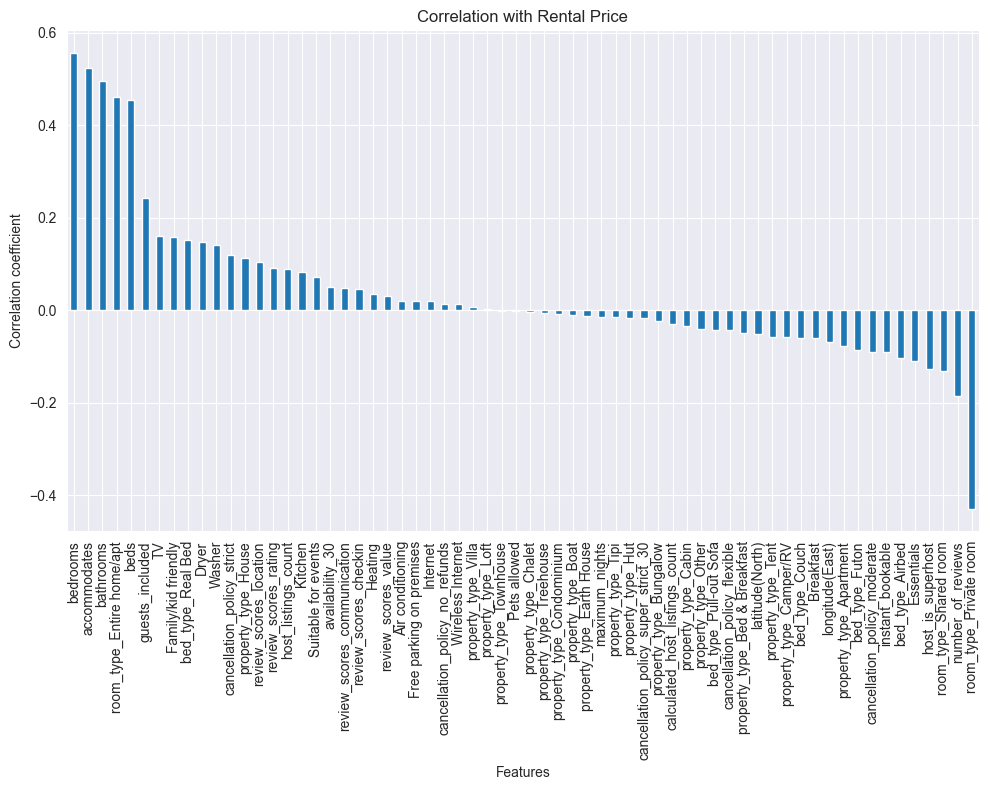

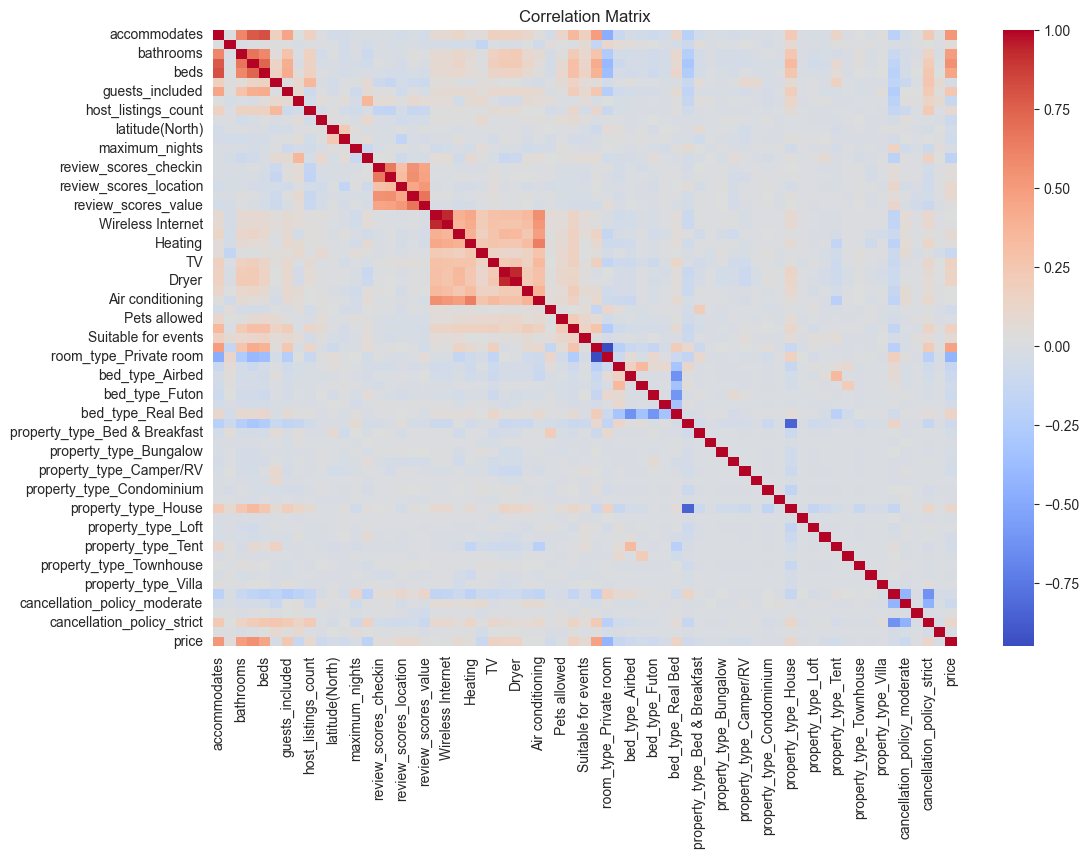

In [46]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Calculate the correlation
correlation_matrix = merged_df.corr()
rental_price_correlation = correlation_matrix['price'].sort_values(ascending=False)
pd.set_option('display.max_columns', None)
print("Correlation with rental price:")
print(rental_price_correlation)
plt.figure(figsize=(10, 8))
rental_price_correlation.drop('price').plot(kind='bar')
plt.title('Correlation with Rental Price')
plt.xlabel('Features')
plt.ylabel('Correlation coefficient')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix,fmt='2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Model training

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R^2': r2}
    print(f"{name} - Mean Squared Error: {mse}, R^2 Score: {r2}")


Linear Regression - Mean Squared Error: 1.248245107984743e+22, R^2 Score: -6.030294650474779e+17
Decision Tree - Mean Squared Error: 16587.709039548023, R^2 Score: 0.19864478182243983
Random Forest - Mean Squared Error: 8307.216075047081, R^2 Score: 0.5986768917638986


Linear Regression - Mean Squared Error: 1.248245107984743e+22, R^2 Score: -6.030294650474779e+17
Decision Tree - Mean Squared Error: 16587.709039548023, R^2 Score: 0.19864478182243983
Random Forest - Mean Squared Error: 8307.216075047081, R^2 Score: 0.5986768917638986


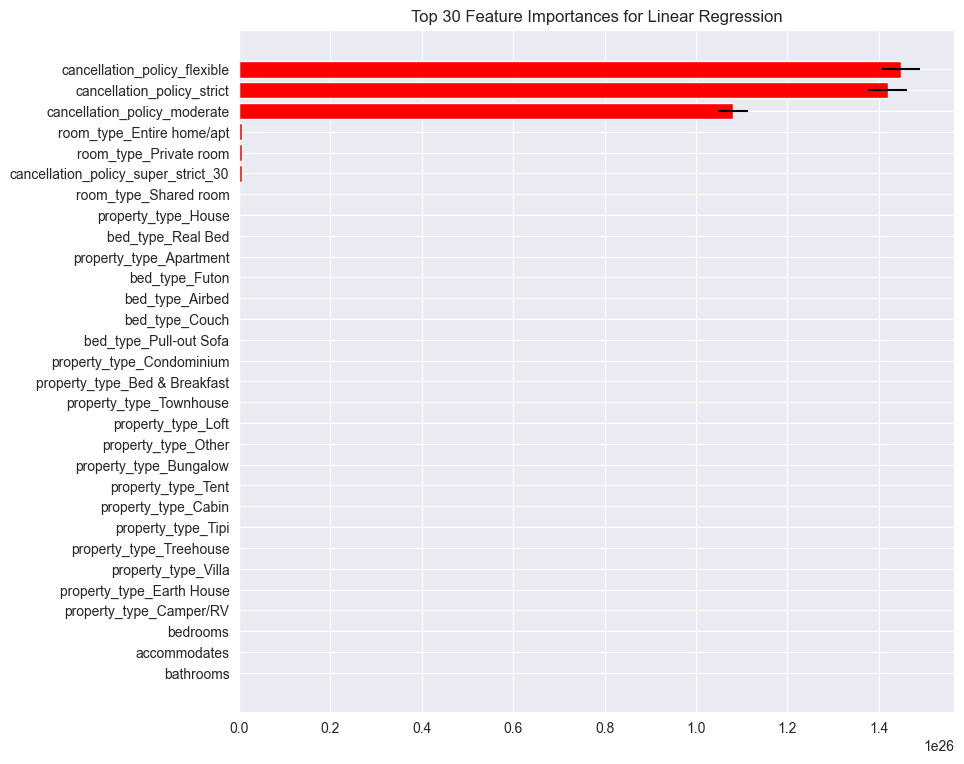

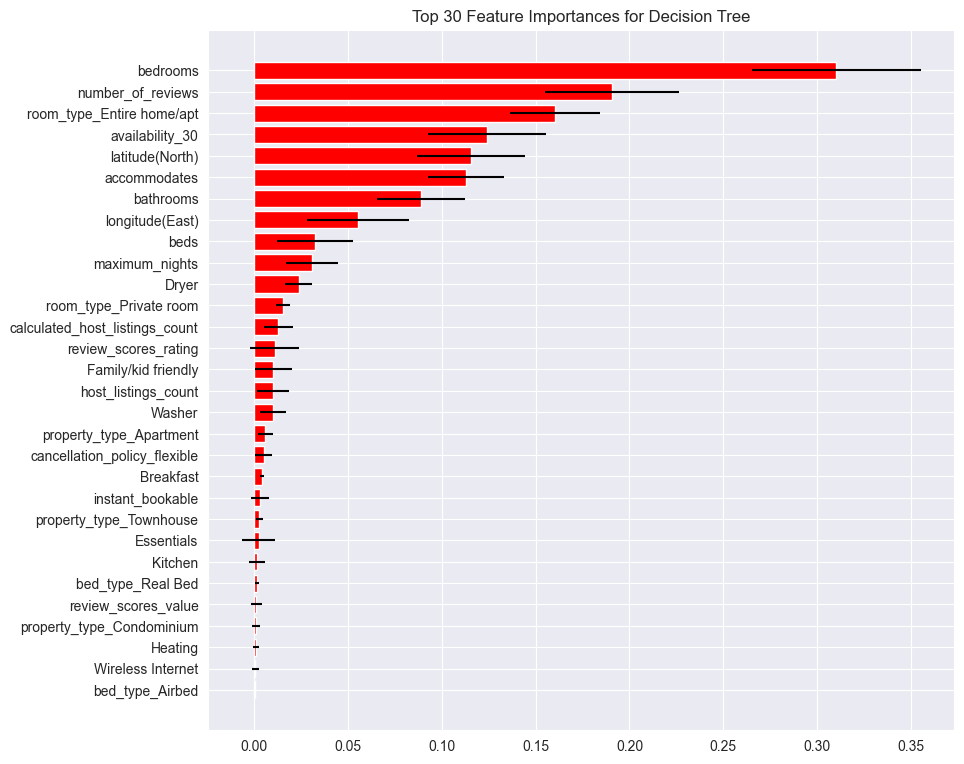

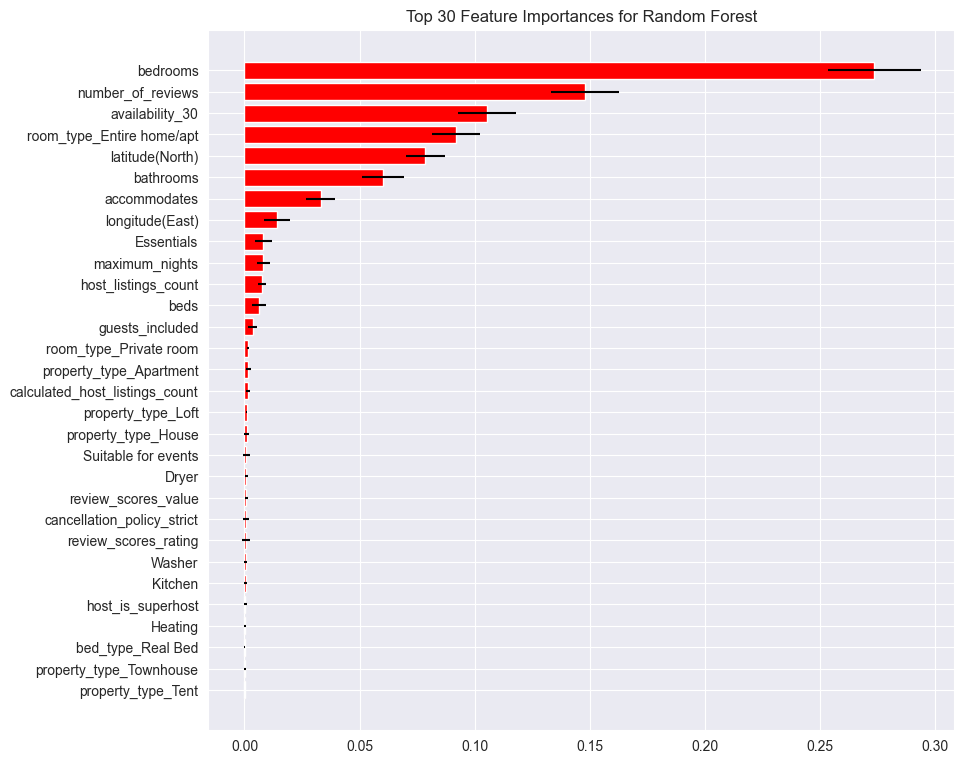

Selected top 30 important features from Random Forest: Index(['bedrooms', 'number_of_reviews', 'availability_30',
       'room_type_Entire home/apt', 'latitude(North)', 'bathrooms',
       'accommodates', 'longitude(East)', 'Essentials', 'maximum_nights',
       'host_listings_count', 'beds', 'guests_included',
       'room_type_Private room', 'property_type_Apartment',
       'calculated_host_listings_count', 'property_type_Loft',
       'property_type_House', 'Suitable for events', 'Dryer',
       'review_scores_value', 'cancellation_policy_strict',
       'review_scores_rating', 'Washer', 'Kitchen', 'host_is_superhost',
       'Heating', 'bed_type_Real Bed', 'property_type_Townhouse',
       'property_type_Tent'],
      dtype='object')
Linear Regression (Selected Features) - Mean Squared Error: 11093.178061862815, R^2 Score: 0.4640865652482641
Decision Tree (Selected Features) - Mean Squared Error: 17261.354990583804, R^2 Score: 0.16610082431874484
Random Forest (Selected Features) 

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# Train base models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Dictionary to store the permutation importance results
permutation_importances = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - Mean Squared Error: {mse}, R^2 Score: {r2}")

    # Calculate permutation importance
    r = permutation_importance(model, X_test, y_test, n_repeats=100, random_state=42)
    permutation_importances[name] = r

# Plot permutation importance for each model
for name, r in permutation_importances.items():
    importances = r.importances_mean
    std = r.importances_std
    indices = np.argsort(importances)[::-1]

    # Limit to top 30 features
    indices = indices[:30]
    importances = importances[indices]
    std = std[indices]
    features_to_plot = X_test.columns[indices]

    plt.figure(figsize=(10, 8))
    plt.title(f"Top 30 Feature Importances for {name}")
    plt.barh(features_to_plot, importances, color="r", xerr=std, align="center")
    plt.gca().invert_yaxis()  # Reverse the order of the features
    plt.tight_layout(pad=2.0)  # Increase space between lines
    plt.show()

# Select the top 30 important features based on Random Forest as an example
model_name = 'Random Forest'
top_n_features = 30
important_features = X_test.columns[np.argsort(permutation_importances[model_name].importances_mean)[::-1][:top_n_features]]
print(f"Selected top {top_n_features} important features from {model_name}: {important_features}")

# Retrain and evaluate models with selected features
X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]

results_selected = {}
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results_selected[name] = {'MSE': mse, 'R^2': r2}
    print(f"{name} (Selected Features) - Mean Squared Error: {mse}, R^2 Score: {r2}")
